# Rotary Stewart Platforms

## Background

This page is designed to show you how to go from a desired platform pose $[x,y,z,\theta_x,\theta_y,\theta_z]^T$ to a set of 6 motor angles $[\theta_{m1},\theta_{m2},\theta_{m3},\theta_{m4},\theta_{m5},\theta_{m6}]^T$. 

This is a challenging task, believe it or not. We will take a step-by-step approach, coding and plotting along the way where appropriate. We will assume that you have some knowledge of vector math, and of rotation matrices. 

## Base Construction

For a 6-DOF rotary Stewart platform, we have 6 motors arranged around in a circular pattern. If we define a "radius" for the base, we can write the "yaw angle" of each motor shaft with respect to a global $XYZ$ coordinate system as:

$$\vec{\psi_m} = \left[0,\frac{\pi}{3},\frac{2\pi}{3},\pi,\frac{4\pi}{3},\frac{5\pi}{3}\right]^T$$

the $XYZ$ coordinate system will be defined so that $X$ points forward with respect to a person sitting in a vehicle on the platform at the platform's resting position, $Y$ so that it points to the driver's left, and $Z$ pointing upwards. This is shown in the figure below.

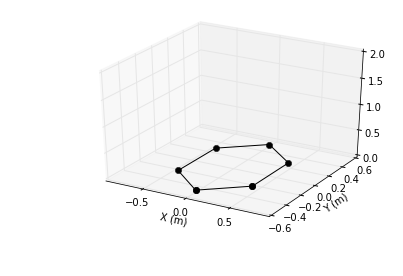

In [6]:
from numpy import *
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = figure()
ax = fig.add_subplot(111, projection='3d')

platform_z0 = 1#meters, the resting height of the base.

baseradius = .5 #meters, the radius of the base
motorarm = 0.2 #meters, length of the motor arm
conrod = sqrt(platform_z0**2+motorarm**2)-.05 #meters, length of the connecting rod
platform_radius = .3#meters, the radius of the platform

#these are the yaw angles at which each motor sits.
motor_yaws = arange(0,6)*pi/3-pi/6

#calculate the positions of the motor shafts. X forward, Y left, Z up.
motor_X = baseradius*cos(motor_yaws)
motor_Y = baseradius*sin(motor_yaws)
motor_Z = zeros(6)

#create a function we can use to plot the base any time.
def plotbase():
    #plot the lines
    ax.plot(motor_X,motor_Y,motor_Z,'k',marker='o')
    #connect the ends
    ax.plot([motor_X[-1],motor_X[0]],[motor_Y[-1],motor_Y[0]],[motor_Z[-1],motor_Z[0]],'k',marker='o')
    for ind in range(0,6):
        annotate(str(ind+1),xy=(motor_X[ind],motor_Y[ind]),xytext=(motor_X[ind],motor_Y[ind]))
plotbase()
xlabel('X (m)')
ylabel('Y (m)')
ax.set_xlim3d(-2*baseradius, 2*baseradius)
ax.set_ylim3d(-2*baseradius,2*baseradius)
ax.set_zlim3d(0,4*baseradius)

axis('equal')
show()

## Platform Construction

Next, we will be placing the triangular platform somewhere above the base. The platform will be located at some pose of our choosing (based on our motion washout algorithms), and we will have to figure out how to get our rotary motors to get us to that position. Below is a function we can use to plot the platform at any time, and a function that associates each of the six motor shaft locations to each of the three platform connection points.

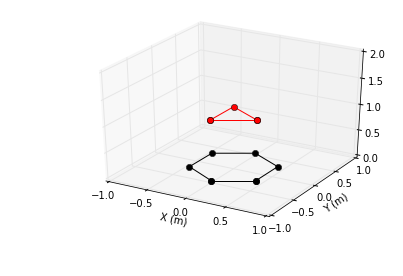

In [10]:
def calculate_P(X,Y,Z,roll,pitch,yaw):
    #our goal is to take a platform pose and calculate a vector of 3 points on an equillateral triangle, to which all 6 motor con rods are attached.
    platform_yaw0 = array([0,2*pi/3,4*pi/3])
    platform_x = platform_radius*cos(platform_yaw0)#the middle of the platform's position, then transformed to each of the triangle's three points.
    platform_y = platform_radius*sin(platform_yaw0)#similar to X
    platform_z = zeros(3) #height of the platform.

    #now, these are NOT rotated like we wanted! so let's rotate them.
    Rx = array([[1,0,0],[0,cos(roll),-sin(roll)],[0,sin(roll),cos(roll)]])
    Ry = array([[cos(pitch),0,sin(pitch)],[0,1,0],[-sin(pitch),0,cos(pitch)]])
    Rz = array([[cos(yaw),-sin(yaw),0],[sin(yaw),cos(yaw),0],[0,0,1]])
    #print Rx
    R = dot(dot(Rx,Ry),Rz)
    #R = eye(3)

    #initialize our vectors of platform point coordinates.
    PX = zeros(3)
    PY = zeros(3)
    PZ = zeros(3)

    #cycle through each of the three platform points and calculate the rotated version.
    for ind in range(0,3):
        currpoint = vstack([platform_x[ind],platform_y[ind],platform_z[ind]])
        rotpoint = dot(R,currpoint)
        PX[ind] = rotpoint[0]+X
        PY[ind] = rotpoint[1]+Y
        PZ[ind] = rotpoint[2]+Z+platform_z0

    return PX,PY,PZ

def plotplatform(PX,PY,PZ):
    #plot the lines
    ax.plot(PX,PY,PZ,'r',marker='o')
    #connect the ends
    ax.plot([PX[-1],PX[0]],[PY[-1],PY[0]],[PZ[-1],PZ[0]],'r',marker='o')
    
#use these two functions to plot base and platform together..
fig = figure()
ax = fig.add_subplot(111, projection='3d')


x,y,z,roll,pitch,yaw = 0,0,0,0,0,0

PX,PY,PZ = calculate_P(x,y,z,roll,pitch,yaw)
plotplatform(PX,PY,PZ)
plotbase()
xlabel('X (m)')
ylabel('Y (m)')
ax.set_xlim3d(-2*baseradius, 2*baseradius)
ax.set_ylim3d(-2*baseradius,2*baseradius)
ax.set_zlim3d(0,4*baseradius)

show()

## Vectors from Base to Platform

In a traditional Stewart platform, with linear actuators, the only thing left to do would be to calculate the distance between the global location of each motor's shaft, which we will call $\vec{r}_{O,i}$ for motor $i$, and the corresponding point on the platform, which we will call $\vec{r}_{P,i}$ for motor $i$. This operation would give us a vector from the motor to the platform, which we call $\vec{r}_{P/O,i}$. Finding the length of this vector, $\left|\vec{r}_{P/O,i}\right|$, yields a measure of the length command we would need to issue to linear actuator $i$.

We could easily plot the vectors $\vec{r}_{P/O,i}$ to show the equivalent linear Stewart platform configuration, and this is shown below.

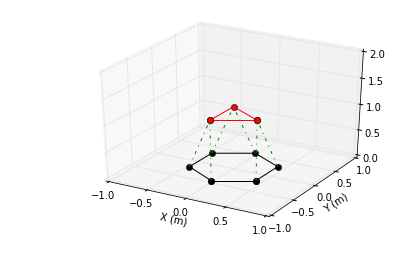

In [12]:
def findrpo(x,y,z,roll,pitch,yaw):
    #first calculate the positions of the three platform points.
    PX,PY,PZ = calculate_P(x,y,z,roll,pitch,yaw)
    #now, use these positions to calculate the platform point corresponding to each motor.
    PX_aligned = array([PX[0],PX[0],PX[1],PX[1],PX[2],PX[2]])
    PY_aligned = array([PY[0],PY[0],PY[1],PY[1],PY[2],PY[2]])
    PZ_aligned = array([PZ[0],PZ[0],PZ[1],PZ[1],PZ[2],PZ[2]])

    #now return the vectors FROM the motors TO the points P.
    return PX_aligned-motor_X,PY_aligned-motor_Y,PZ_aligned-motor_Z

def plotlegs(RPO_X,RPO_Y,RPO_Z):
    for ind in range(0,6):
        ax.plot([motor_X[ind],motor_X[ind]+RPO_X[ind]],[motor_Y[ind],motor_Y[ind]+RPO_Y[ind]],[motor_Z[ind],motor_Z[ind]+RPO_Z[ind]],'g-.')

#use these two functions to plot base and platform together..
fig = figure()
ax = fig.add_subplot(111, projection='3d')


#get our position command for the platform
x,y,z,roll,pitch,yaw = 0,0,0,0,0,0
#calculate the positions of the platform points P, one for each motor.
PX,PY,PZ = calculate_P(x,y,z,roll,pitch,yaw)
#calculate the relative position of the points P with respect to the points O
rpox,rpoy,rpoz = findrpo(x,y,z,roll,pitch,yaw)

plotplatform(PX,PY,PZ)
plotbase()
plotlegs(rpox,rpoy,rpoz)
xlabel('X (m)')
ylabel('Y (m)')
ax.set_xlim3d(-2*baseradius, 2*baseradius)
ax.set_ylim3d(-2*baseradius,2*baseradius)
ax.set_zlim3d(0,4*baseradius)

show()


## Coordinates of the motor arms

Unfortunately, with a rotary Stewart platform, we don't have the luxury of setting leg lengths directly. Because of this, we have to perform a few extra steps that are a bit messy. The first order of business is to calculate, in the global coordinate system, the locations of the motor arms for each motor. We will call these global positions $\vec{r}_{Q,i}$. For each individual motor, 

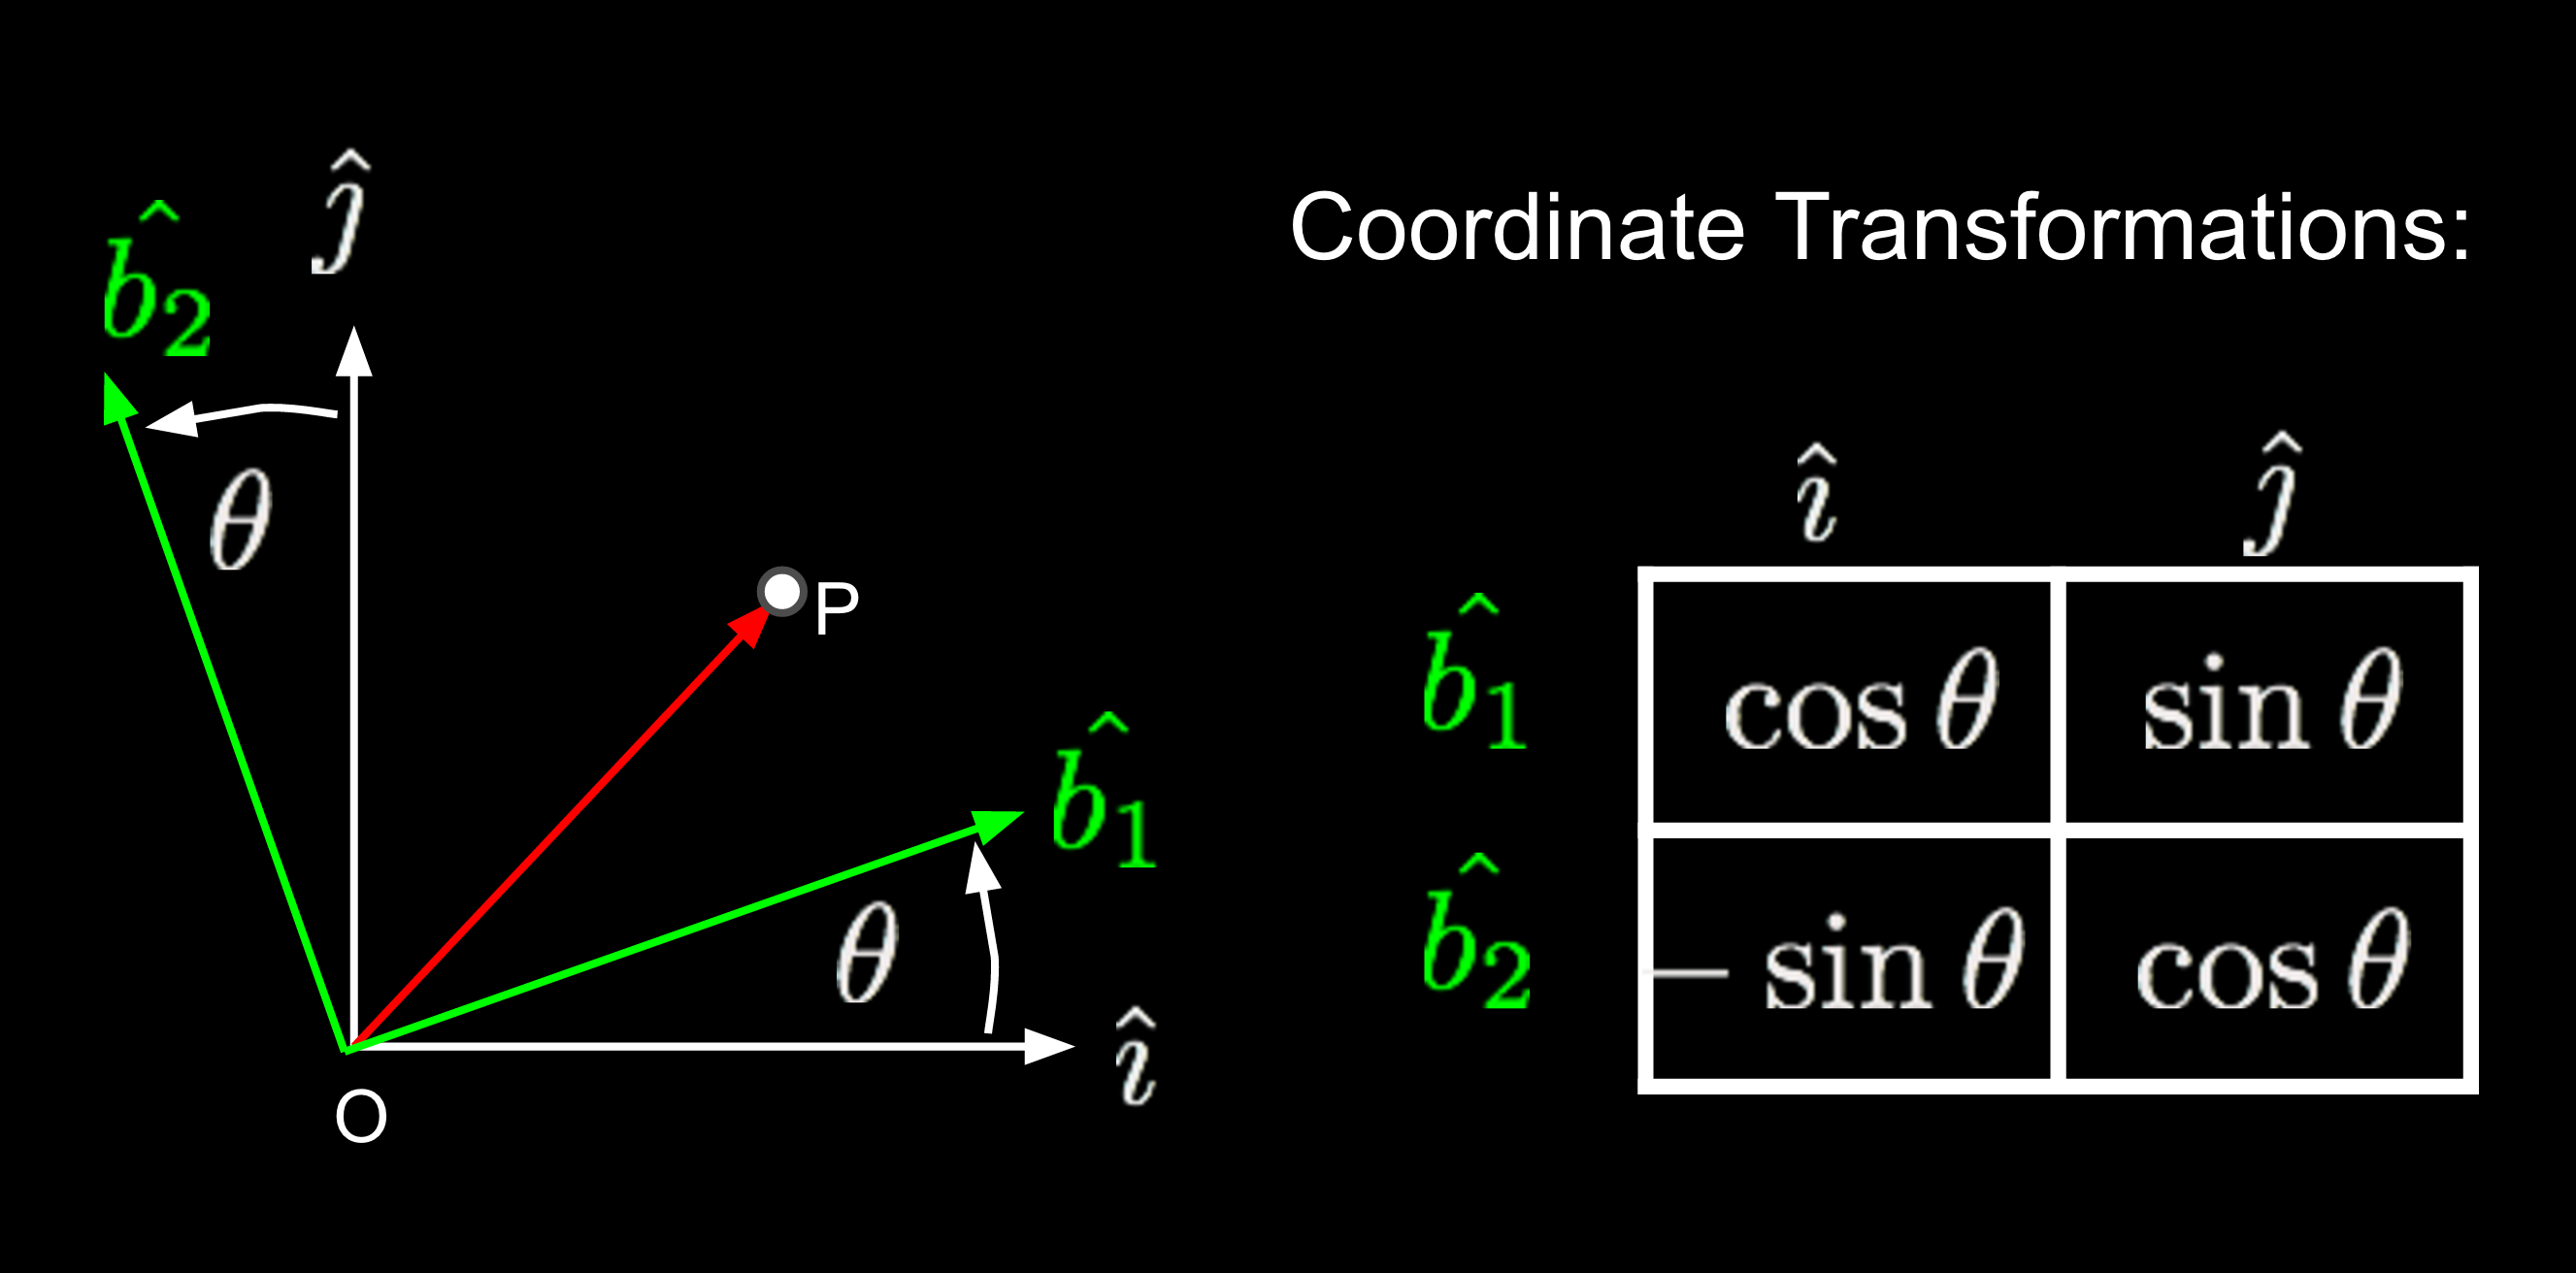

In [13]:
from IPython.core.display import Image 
Image('coord_xforms.png') 